In [12]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from sklearn.preprocessing import LabelEncoder
from keras.models import model_from_json
import numpy as np

In [2]:
data = pd.read_csv('Sentiment.csv')
# Keeping only the neccessary columns
data = data[['text','sentiment']]

data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))
data.head(5)

,text,sentiment
0,rt nancyleegrahn how did everyone feel about t...,Neutral
1,rt scottwalker didnt catch the full gopdebate ...,Positive
2,rt tjmshow no mention of tamir rice and the go...,Neutral
3,rt robgeorge that carly fiorina is trending h...,Positive
4,rt danscavino gopdebate w realdonaldtrump deli...,Positive


In [3]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)

X = pad_sequences(X)

embed_dim = 128
lstm_out = 196

In [4]:
def createmodel():
    model = Sequential()
    model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    return model

In [5]:
labelencoder = LabelEncoder()
integer_encoded = labelencoder.fit_transform(data['sentiment'])
y = to_categorical(integer_encoded)
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.33, random_state = 42)

In [6]:
batch_size = 32
model = createmodel()
model.fit(X_train, Y_train, epochs = 1, batch_size=batch_size, verbose = 2)
score,acc = model.evaluate(X_test,Y_test,verbose=2,batch_size=batch_size)
print(score)
print(acc)
print(model.metrics_names)

291/291 - 41s - loss: 0.8233 - accuracy: 0.6467
144/144 - 2s - loss: 0.7563 - accuracy: 0.6732
0.7563328742980957
0.6732197403907776
['loss', 'accuracy']


In [7]:
#convert model to json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

In [8]:
#Load model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")


In [9]:
#evaluate model
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X, y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1] * 100))

accuracy: 70.41%


In [14]:
tweet = ['A lot of good things are happening. We are respected again throughout the world, and thats a great thing.@realDonaldTrump']

# vectorizing the tweet by the pre-fitted tokenizer instance
tweet = tokenizer.texts_to_sequences(tweet)

# padding the tweet to have exactly the same shape as `embedding_2` input
tweet = pad_sequences(tweet, maxlen=28, dtype='int32', value=0)
print(tweet)
sentiment = model.predict(tweet, batch_size=1, verbose=2)[0]
print(sentiment)
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   8 439   6 144 290  36  31
   36 372   2 347   9 261   8 151 264  24]]
1/1 - 0s
[0.52408195 0.15337622 0.32254183]
negative


In [19]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=5, batch_size=32)
# history = model.fit(X_train, Y_train, epochs = 5, batch_size=batch_size, verbose = 2,  callbacks=[tensorborad])
score,acc = model.evaluate(X_test,Y_test,verbose=2,batch_size=batch_size)
from keras.models import load_model
# model.save('model.h5')
print(score)
print(acc)

Epoch 1/5
291/291 [==============================] - 37s 126ms/step - loss: 0.6789 - accuracy: 0.7104 - val_loss: 0.7396 - val_accuracy: 0.6798
Epoch 2/5
291/291 [==============================] - 48s 166ms/step - loss: 0.6109 - accuracy: 0.7441 - val_loss: 0.7430 - val_accuracy: 0.6830
Epoch 3/5
291/291 [==============================] - 44s 151ms/step - loss: 0.5590 - accuracy: 0.7658 - val_loss: 0.7797 - val_accuracy: 0.6791
Epoch 4/5
291/291 [==============================] - 45s 155ms/step - loss: 0.5164 - accuracy: 0.7840 - val_loss: 0.8339 - val_accuracy: 0.6833
Epoch 5/5
291/291 [==============================] - 46s 158ms/step - loss: 0.4757 - accuracy: 0.8035 - val_loss: 0.8759 - val_accuracy: 0.6531
144/144 - 3s - loss: 0.8759 - accuracy: 0.6531
0.8758540749549866
0.6531236171722412


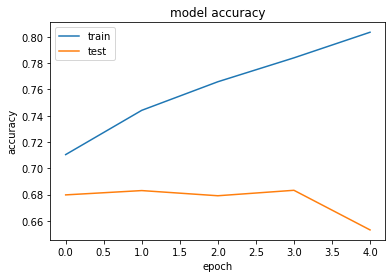

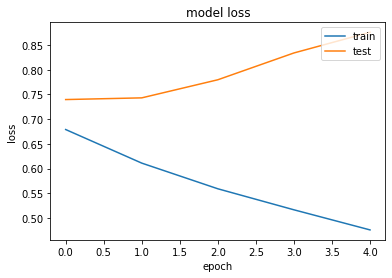

In [21]:
#bonus
#accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()